# Practical task sheet 03 -- streaming, dash, playout
The third task sheet will cover topics related to streaming, dash and palying out videos with html5,

To prepare for the tasks the following material should be checked out:

* https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol
* https://en.wikipedia.org/wiki/Dynamic_Adaptive_Streaming_over_HTTP
* https://netflixtechblog.com/dynamic-optimizer-a-perceptual-video-encoding-optimization-framework-e19f1e3a277f
* https://netflixtechblog.com/html5-and-video-streaming-a3563b19eb02


**General Hint**: in each code cell the parts where code needs to be added is marked with TBD, prefer simple code than complicated.
It is further not a problem if you cannot solve all tasks.

In [1]:
# version 2.2

In [2]:
# install requirements (this cell should not produce any errors, otherwise check dependencies and guide)
!pip3 install --user numpy pandas matplotlib scipy jupyter scikit-image scikit-learn scikit-video

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [3]:
# helper functions
import os
# add the local path of the "to be downloaded ffmpeg and ffprobe" to the search path
os.environ["PATH"] = "tools" + os.pathsep + os.environ["PATH"]

import platform
import shutil 
import urllib.request
import glob
import socket  # we use the python socket API
import re


# enables inline plots
%matplotlib inline  

import numpy as np
# fix for numpy and scikitvideo
np.int = int
np.float = float
np.bool = bool

from scipy.fftpack import dct, idct


import xml.etree.ElementTree as ET


import pandas as pd
from IPython.display import display as d  # display nice tables in jupyter
from IPython.core.display import HTML

import skimage.io
import numpy as np
import io


def show_image(img):
    """ shows an image (3d array) in a jupytor cell"""
    skimage.io.imshow(img)
    skimage.io.show()

    
def show_image_byte_array(byte_array):
    """ shows an image that is provided as binary string"""
    img_ = io.BytesIO(byte_array)
    img = skimage.io.imread(img_)
    show_image(img)
    

# ffmepg & ffprobe specific

def _get_file(url, target_filename_and_path):
    """
    downloads a file from `url` to `target_filename_and_path`
    """
    if os.path.isfile(target_filename_and_path):
        # prevent of downloading several times
        return True
    try:
        urllib.request.urlretrieve(url, target_filename_and_path)
    except urllib.error.URLError as e:
        return False
    return True

def download_local_ffmpeg_ffprobe():
    """ will download binaries for ffprobe to tools directory """
    print("download local installed ffmpeg and ffprobe for your OS, download will take some time")
    os.makedirs("tools", exist_ok=True)

    ffprobe_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/S4ZR97kdpgCS7pD/download",
            "exe": os.path.join("tools", "ffprobe.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/XgT4NWjqNrtjkNK/download",
            "exe": os.path.join("tools", "ffprobe")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/sT23KSsD3XRw9yb/download",
            "exe": os.path.join("tools", "ffprobe")
        }
    }
    ffmpeg_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/dnWb9nkp4t3TRx6/download",
            "exe": os.path.join("tools", "ffmpeg.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/QxYxgpqo8DtzQDk/download",
            "exe": os.path.join("tools", "ffmpeg")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/f2nFkomjNQecScr/download",
            "exe": os.path.join("tools", "ffmpeg")
        }
    }

    ffprobe = shutil.which("ffprobe") # system version as fallback, not sure if this works for Windows
    ffmpeg = shutil.which("ffmpeg")

    make_executable = False
    os_name = "default"
    os_mapping = {
        "Windows": "win",
        "Darwin": "macos",
        "Linux": "linux"
    }
    if platform.system() in os_mapping:
        os_name = os_mapping[platform.system()]

    if os_name in ffprobe_links:
        tmp = _get_file(ffprobe_links[os_name]["link"], ffprobe_links[os_name]["exe"])
        ffprobe = ffprobe_links[os_name]["exe"]

    if os_name in ffmpeg_links:
        tmp = _get_file(ffmpeg_links[os_name]["link"], ffmpeg_links[os_name]["exe"])
        ffmpeg = ffmpeg_links[os_name]["exe"]

    if os_name in ["linux", "macos"]:
        os.system(f"chmod +x {ffprobe}")  # not sure if this works for MACOS, or is even required
        os.system(f"chmod +x {ffmpeg}")

    print(f"ffmpeg executable used {ffmpeg}")
    print(f"ffprobe executable used {ffprobe}")
    return ffmpeg, ffprobe

ffmpeg, ffprobe = download_local_ffmpeg_ffprobe()
# end of ffmepg & ffprobe specific

import skvideo.io

download local installed ffmpeg and ffprobe for your OS, download will take some time
ffmpeg executable used tools/ffmpeg
ffprobe executable used tools/ffprobe


## Subtask 1: HTTP Get 
The first subtask will be about HTTP GET requests.

Here we will use the socket api provided by python3 (see import in first code cell, `import socket`)

Start the provided `echo_server.py` script in a separate terminal, e.g. `python3 echo_server.py` or `python echo_server.py`.

Afterwards implement the following simple client.
The server that is provided is a minimalistic echo server.

**Important**: it could be that under windows a firewall warning will occur, please allow connection to the specifed port

In [4]:
import socket
import threading

def start_echo_server():
    host = '127.0.0.1'
    port = 65423

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as server_socket:
        server_socket.bind((host, port))
        server_socket.listen()
        print(f"Server started on {host}:{port} (waiting for connection...)")

        conn, addr = server_socket.accept()
        with conn:
            print(f"Connected by {addr}")
            while True:
                data = conn.recv(1024)
                if not data:
                    break
                conn.sendall(data)

# Run server in background thread
server_thread = threading.Thread(target=start_echo_server, daemon=True)
server_thread.start()


Server started on 127.0.0.1:65423 (waiting for connection...)
Connected by ('127.0.0.1', 57807)


In [5]:
import socket
import time

# Wait briefly to ensure the server has started
time.sleep(1)

host = '127.0.0.1'
port = 65423

# Create a socket and connect to the server
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((host, port))
    message = "hello world"
    s.sendall(message.encode('utf-8'))  # Send message to server
    data = s.recv(1024)                 # Receive response
    print("Received:", data.decode('utf-8'))


Received: hello world


In [6]:
import socket

host = 'exmple.com'
port = 80  # stndrd HTTP port

# Create socket , connect to the server
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((host, port))

    # Construct,send a raw HTTP GET request
    request = "GET / HTTP/1.1\r\nHost: exmple.com\r\nConnection: close\r\n\r\n"
    s.sendall(request.encode('utf-8'))

    # Receive response in chunks
    response = b""
    while True:
        data = s.recv(4096)
        if not data:
            break
        response += data

    # Decode  the HTTP response
    print(response.decode('utf-8', errors='replace'))


HTTP/1.1 200 OK
Date: Fri, 13 Jun 2025 18:16:48 GMT
Server: Apache/2
X-Powered-By: PHP/5.6.40
Vary: Accept-Encoding,User-Agent
Content-Length: 2301
Connection: close
Content-Type: text/html; charset=UTF-8

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
<head>
<title>Example Website, Exmple Website - Exmple.com</title>
  <meta name="description" content="This is an example website that can be used as a demo when creating a dummy link for demonstration purposes.">
  <meta name="keywords" content="Exmple,Example,Exmple.com">
</head>

<body>

<center><table style="margin-top: 2px" width=640><tr><td>

<h2>Example Website</h2>

<p>This is an example website that can be used to demonstrate links without really linking
    to any real site. The domains example.com, example.net and example.org are reserved
    and cannot be followed through a link, while this misspelled domain exmple.com work
    as intended when linked to.
    

<p>The main page if this example website i

The provided simple client is just really minimalistic and there is no advanced protocol defined 
for the communication process.
There are plenty of protocols defined, e.g. XMPP, FTP, SMTP, SIP, RTP, HTTP.
In the following we will just consider HTTP. 
Here the most recent version HTTP/2 or even HTTP3 are binary formats, that are further compressed, see [HTTP/2](https://en.wikipedia.org/wiki/HTTP/2), [HTTP/3](https://en.wikipedia.org/wiki/HTTP/3), for our purpose we will just handle HTTP/1* in the following tasks.

### Subtask 1.1: Manual HTTP GET

One fundamental part of streaming is based on network, and network transmission, so in this task the overall idea is to establish connections using sockets and to download content.

A usual, e.g. GET request using the HTTP protocol ends with a message transmitted that consists of a HEADER, and a Message BODY, the BODY can be text (e.g. in case of a webpage) or binary data in case of e.g. an image.

So first we will create a method to split a message into header and reamining body parts.
Later we will parse the HEADER, and finally we will write a method to perform HTTP GET requests.


In [7]:
def split_header_body(msg):
    """parses a message to get header and body parts, 
    important \r\n is used as line break in HTTP
    """
    header_end = msg.find(b"\r\n\r\n")
    header = msg[:header_end]
    body = msg[header_end + 4:]  # skip the '\r\n\r\n'
    return header, body


# Test
msg_example = b'HTTP/1.0 200 OK\r\nServer: SimpleHTTP/0.6 Python/3.6.9\r\nDate: Tue, 19 May 2020 09:24:49 GMT\r\nContent-type: text/html\r\nContent-Length: 292\r\nLast-Modified: Mon, 18 May 2020 16:16:08 GMT\r\n\r\nBODY'
header, body = split_header_body(msg_example)
print("header", header)
print("body", body)
assert body == b"BODY"


header b'HTTP/1.0 200 OK\r\nServer: SimpleHTTP/0.6 Python/3.6.9\r\nDate: Tue, 19 May 2020 09:24:49 GMT\r\nContent-type: text/html\r\nContent-Length: 292\r\nLast-Modified: Mon, 18 May 2020 16:16:08 GMT'
body b'BODY'


In [8]:
def parse_header(header):
    """
    Parses HTTP header bytes into a dictionary with lowercase keys.
    """
    header_lines = str(header, "utf-8").split("\r\n")
    header_dict = {}
    for i, line in enumerate(header_lines):
        if i == 0:
            header_dict["protocol"] = line
        elif ": " in line:
            key, value = line.split(": ", 1)
            header_dict[key.lower()] = value
    return header_dict



header_example = b'HTTP/1.0 200 OK\r\nServer: SimpleHTTP/0.6 Python/3.6.9\r\nDate: Tue, 19 May 2020 09:24:49 GMT\r\nContent-type: text/html\r\nContent-Length: 292\r\nLast-Modified: Mon, 18 May 2020 16:16:08 GMT\r\n\r\n'
print(parse_header(header_example))

assert parse_header(header_example) == {
    'protocol': 'HTTP/1.0 200 OK',
    'server': 'SimpleHTTP/0.6 Python/3.6.9',
    'date': 'Tue, 19 May 2020 09:24:49 GMT',
    'content-type': 'text/html',
    'content-length': '292',
    'last-modified': 'Mon, 18 May 2020 16:16:08 GMT'
}


{'protocol': 'HTTP/1.0 200 OK', 'server': 'SimpleHTTP/0.6 Python/3.6.9', 'date': 'Tue, 19 May 2020 09:24:49 GMT', 'content-type': 'text/html', 'content-length': '292', 'last-modified': 'Mon, 18 May 2020 16:16:08 GMT'}


In [9]:
import socket

def http_get_request(url, port, what="/"):
    """Performs a HTTP GET request and returns the result."""
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((url, port))
        
        request = f"GET {what} HTTP/1.0\r\nHost: {url}\r\n\r\n"
        s.sendall(request.encode())

        response = b""
        while True:
            data = s.recv(1024)
            if not data:
                break
            response += data

        header, body = split_header_body(response)
        header_dict = parse_header(header)
        
        http_response = body

        # If content-length is available, read exactly that many bytes
        if "content-length" in header_dict:
            expected_len = int(header_dict["content-length"])
            while len(http_response) < expected_len:
                more_data = s.recv(1024)
                if not more_data:
                    break
                http_response += more_data

        # Check content-type
        if "content-type" in header_dict and "text" in header_dict["content-type"]:
            return http_response.decode("utf-8", errors="replace")

        return http_response


In [10]:
# the following python3 call can be used to create a simple web server
print(http_get_request("avtshare01.rz.tu-ilmenau.de", 80, "/vst/2024/server_script.sh"))

b'#!/bin/bash\npython3 -m http.server 8024\n\n'


/var/folders/_x/2gztpbn159g4r624r2bq7jk80000gn/T/ipykernel_58663/3200353354.py:40: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(img)
/var/folders/_x/2gztpbn159g4r624r2bq7jk80000gn/T/ipykernel_58663/3200353354.py:41: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.show()


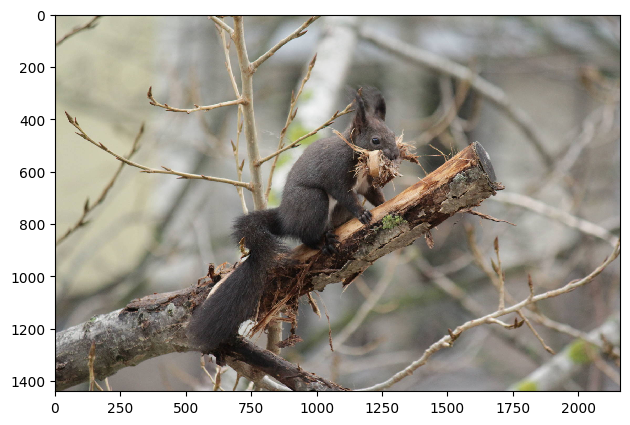

In [11]:
# lets download one image
img = http_get_request("avtshare01.rz.tu-ilmenau.de", 80, "/vst/2024/image.jpg")
show_image_byte_array(img)

### Subtask 1.2: HTTPS GET with urllib
So far we implemented a simple HTTP 1.1 GET method, 
in a similar fashion POST, PUT, DELETE HTTP requests can be implemented, they are usually referred as REST operations, see https://en.wikipedia.org/wiki/Representational_state_transfer.
For the next task we will use the urllib.request python3 library.
This library will also handle e.g. HTTPS connections transparently and can be used for even more, however we only focus on HTTP/HTTPS get requests, because they are needed for DASH based streaming.


/var/folders/_x/2gztpbn159g4r624r2bq7jk80000gn/T/ipykernel_59975/3200353354.py:40: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(img)
/var/folders/_x/2gztpbn159g4r624r2bq7jk80000gn/T/ipykernel_59975/3200353354.py:41: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.show()


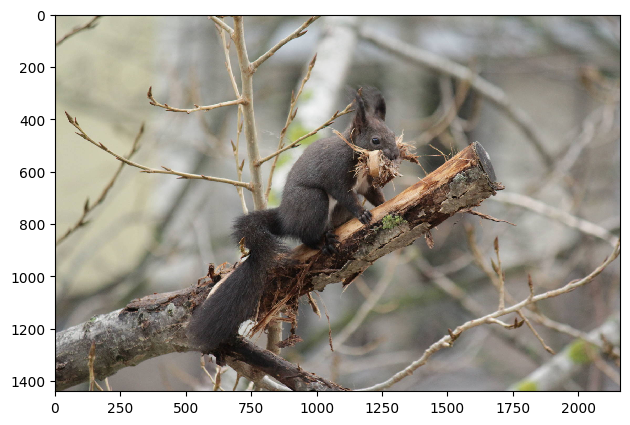

In [10]:
import urllib.request
def get_request(url):
    """
    use urllib.request methods to perform a get request 
    
    again if the content type is text, return a utf-8 encoded string
    otherwise return the byte data
    

    """
    # TBD start
        # Open the URL
    with urllib.request.urlopen(url) as response:
        content_type = response.headers.get("Content-Type", "").lower()
        data = response.read()
        
        if "text" in content_type:
            return data.decode("utf-8", errors="replace")
        else:
            return data

    
    # TBD end
    return data

# note the URLs are different here compared to the cells before, 
# but the content is the same, only the protocol differs, HTTP vs HTTPS.
img = get_request("https://avtshare01.rz.tu-ilmenau.de/vst/2024/image.jpg")
show_image_byte_array(img)

HTML(
    get_request("https://avtshare01.rz.tu-ilmenau.de/vst/2024/index.html")
)

## Subtask 2: DASH
So far we are able to perform simple HTTP/S requests. HTTP forms the fundamental protocoll for many of today's applications. It was developed for plain-text/webpages. Due to its simplicitity it is even used for multimedia instead of more advanced protocols, that e.g. require a "smarter" server.

A DASH video is delivered using HTTP, first a manifest file will be requested later multimedia-segments.



<img src="dashserver.svg" alt="dash client server" style="width:60%" >


In the following tasks we will checkout in detail DASH. 

### Subtask 2.1: A simple DASH player inside Jupyter

Using the %%html magic function of Jupyter it is possible to embed html inside a code cell.
In the next cell, we load the DASHJS player javascript, and create a video player html5 element.
Checkout the guide provided here: https://github.com/Dash-Industry-Forum/dash.js/blob/development/README.md to embed the player to play the manifest file provided at [https://avtshare01.rz.tu-ilmenau.de/vst/schachmatt/schachmatt_manifest.mpd](https://avtshare01.rz.tu-ilmenau.de/vst/schachmatt/schachmatt_manifest.mpd).


In [11]:
%%html

<script src="https://cdnjs.cloudflare.com/ajax/libs/dashjs/3.1.0/dash.all.min.js"></script>

<video id="videoPlayer" controls style="width: 640px; height: 360px;"></video>

<script>
    (function(){
        var url = "https://avtshare01.rz.tu-ilmenau.de/vst/2024/schachmatt/schachmatt_manifest.mpd";
        
        // Create the DASH player instance
        var player = dashjs.MediaPlayer().create();
        
        // Initialize the player and bind it to the video element
        player.initialize(document.querySelector("#videoPlayer"), url, true);
    })();
</script>


### Subtask 2.2: Inspecting and parsing the manifestfile
The main entry point for DASH playout is a manifestfile. (other HTTP based streaming approaches, e.g. HLS have a similar concept, but the format differs).

Use the `get_request` method to request the given manifest file, convert it to a utf-8 string, because it is not shipped as content-type text.

In [12]:
import socket
from urllib.parse import urlparse

def get_request(url):
    parsed = urlparse(url)
    host = parsed.hostname
    path = parsed.path
    port = 80

    request = f"GET {path} HTTP/1.1\r\nHost: {host}\r\nConnection: close\r\n\r\n"

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((host, port))
        s.sendall(request.encode('utf-8'))

        response = b""
        while True:
            data = s.recv(4096)
            if not data:
                break
            response += data

    # Split HTTP headers and body
    header_end = response.find(b"\r\n\r\n")
    body = response[header_end + 4:]

    return body

manifest_url = "https://avtshare01.rz.tu-ilmenau.de/vst/2024/schachmatt/schachmatt_manifest.mpd"
manifest = get_request(manifest_url).decode("utf-8")
print(manifest)


<?xml version="1.0" encoding="utf-8"?>
<MPD xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
	xmlns="urn:mpeg:dash:schema:mpd:2011"
	xmlns:xlink="http://www.w3.org/1999/xlink"
	xsi:schemaLocation="urn:mpeg:DASH:schema:MPD:2011 http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-DASH_schema_files/DASH-MPD.xsd"
	profiles="urn:mpeg:dash:profile:isoff-live:2011"
	type="static"
	mediaPresentationDuration="PT2M55.7S"
	minBufferTime="PT4.0S">
	<ProgramInformation>
	</ProgramInformation>
	<Period id="0" start="PT0.0S">
		<AdaptationSet id="0" contentType="video" segmentAlignment="true" bitstreamSwitching="true" lang="eng">
			<Representation id="0" mimeType="video/mp4" codecs="avc1.64001e" bandwidth="58868" width="426" height="240" frameRate="60/1">
				<SegmentTemplate timescale="1000000" duration="2000000" initialization="init-stream$RepresentationID$.m4s" media="chunk-stream$RepresentationID$-$Number%05d$.m4s" startNumber="1">
				</SegmentTemplate>
			</Representation>
			<R

In [13]:
import xml.etree.ElementTree as ET
import pandas as pd
from IPython.display import display as d

manifest_xml = ET.fromstring(manifest)

video_infos = []

# define MPEG-DASH namespace
ns = {'mpd': 'urn:mpeg:dash:schema:mpd:2011'}

# find  video representations using XPath
representations = manifest_xml.findall(".//mpd:AdaptationSet[@contentType='video']/mpd:Representation", ns)

for rep in representations:
    info = {
        'height': rep.get('height'),
        'codecs': rep.get('codecs'),
        'bandwidth': rep.get('bandwidth'),
        'frameRate': rep.get('frameRate')
    }
    video_infos.append(info)

# display  dataframe
d(pd.DataFrame(video_infos))


,height,codecs,bandwidth,frameRate
0,240,avc1.64001e,58868,60/1
1,360,avc1.64001f,100223,60/1
2,576,avc1.640020,285808,60/1
3,720,avc1.640020,548652,60/1
4,1080,avc1.64002a,1093701,60/1


In [14]:
# use XPath to find  SegmentTemplate of  video representation
segment_template = manifest_xml.find(".//{urn:mpeg:dash:schema:mpd:2011}AdaptationSet[@contentType='video']/{urn:mpeg:dash:schema:mpd:2011}Representation/{urn:mpeg:dash:schema:mpd:2011}SegmentTemplate")

duration = segment_template.get("duration")
print(duration)


2000000


### Subtask 2.3

Now we want to manually download video data of one representation.
Important here is that a DASH stream consists of two parts:
First, the `initialization` file, that includes all header information of the video, e.g. which codec, which color subsampling, which resolution.
This initialization segment can be requested for each representation, if e.g. during playout a quality switch is performed, the initialization segment of the new representation is required.



In [15]:
import xml.etree.ElementTree as ET
from urllib.parse import urlparse
import os

# Parse the manifest again (just in case)
manifest_xml = ET.fromstring(manifest)
ns = {'mpd': 'urn:mpeg:dash:schema:mpd:2011'}

# 1. Select representation with height 576
representation = manifest_xml.find(".//mpd:Representation[@height='576']", ns)

# 2. Extract representation ID
rep_id = representation.get("id")

# 3. Get initialization sub-URL
segment_template = representation.find("mpd:SegmentTemplate", ns)
init = segment_template.get("initialization")

# 4. Get media sub-URL
media = segment_template.get("media")

# 5. Get startNumber
start_number = int(segment_template.get("startNumber"))

# 6. Get base URL from manifest
parsed = urlparse(manifest_url)
base_url = os.path.dirname(f"{parsed.scheme}://{parsed.netloc}{parsed.path}")

# Print results
print(rep_id)
print(init)
print(media)
print(start_number)
print(base_url)


2
init-stream$RepresentationID$.m4s
chunk-stream$RepresentationID$-$Number%05d$.m4s
1
https://avtshare01.rz.tu-ilmenau.de/vst/2024/schachmatt


In [16]:
import re

def perform_template_substitution(template, representation, number):
    # Replace $RepresentationID$
    result = template.replace("$RepresentationID$", str(representation))

    # Replace $Number%0Xd$
    match = re.search(r"\$Number%0(\d+)d\$", result)
    if match:
        width = int(match.group(1))
        formatted_number = f"{number:0{width}d}"
        result = re.sub(r"\$Number%0\d+d\$", formatted_number, result)
    
    return result

# Tests
print(perform_template_substitution(init, rep_id, 0))
print(perform_template_substitution(media, rep_id, start_number))

init_example = "init-stream$RepresentationID$.m4s"
media_example = "chunk-stream$RepresentationID$-$Number%04d$.m4s"

assert(perform_template_substitution(init_example, 2, 0) == "init-stream2.m4s")
assert(perform_template_substitution(media_example, 2, 1) == "chunk-stream2-0001.m4s")
assert(perform_template_substitution(media_example, 3, 10) == "chunk-stream3-0010.m4s")


init-stream2.m4s
chunk-stream2-00001.m4s


In [17]:
# 1. Format segment URLs
init_f = perform_template_substitution(init, rep_id, 0)
media_f = perform_template_substitution(media, rep_id, start_number)

# 2. Download segments
init_segment = get_request(f"{base_url}/{init_f}")
media_segment = get_request(f"{base_url}/{media_f}")

# 3. Combine and write to MP4
video = init_segment + media_segment

with open("video_start.mp4", "wb") as f:
    f.write(video)


In [18]:
%%html
<p>we use the plain vanilla html5 video tag to show the stored video inside jupyter</p>

<video id="videoPlayer" src="video_start.mp4" controls></video>


In [ ]:
from urllib.error import HTTPError

def download_representation(manifest_url, video_filename, video_height):
    manifest = get_request(manifest_url).decode("utf-8")
    manifest_xml = ET.fromstring(manifest)
    ns = {'mpd': 'urn:mpeg:dash:schema:mpd:2011'}

    # Find representation by height
    rep = manifest_xml.find(f".//mpd:Representation[@height='{video_height}']", ns)
    rep_id = rep.get("id")
    seg_tmpl = rep.find("mpd:SegmentTemplate", ns)

    init = seg_tmpl.get("initialization")
    media = seg_tmpl.get("media")
    start_number = int(seg_tmpl.get("startNumber"))

    parsed = urlparse(manifest_url)
    base_url = os.path.dirname(f"{parsed.scheme}://{parsed.netloc}{parsed.path}")

    init_url = f"{base_url}/{perform_template_substitution(init, rep_id, 0)}"
    video = get_request(init_url)

    seg_number = start_number
    while True:
        try:
            seg_url = f"{base_url}/{perform_template_substitution(media, rep_id, seg_number)}"
            segment = get_request(seg_url)
            video += segment
            seg_number += 1
        except Exception as e:
            print(f"Stopping at segment {seg_number}: {e}")
            break

    with open(video_filename, "wb") as f:
        f.write(video)

download_representation(manifest_url, "video_576.mp4", 576)


In [ ]:
%%html
<p>lets check the downloaded video</p>

<video id="videoPlayer" src="video_576.mp4" controls></video>

## Subtask 3: DASH encoding
Until now, we got some ideas how the communication and downloading of a DASH video representation (and btw in an analog way for audio, and pure audio streaming) is working. 
Open for a DASH player would be the following topics handling of quality switches during download, measuring the bandwith and buffering the video while playing.

However, we do not know so far one fundamental part: how videos are encoded for DASH streaming.

            
<img src="dashclient.svg" alt="dash client" style="width:60%" >


As it can be seen, also in the given example manifest file, different video represenations are required.
They can be, e.g., based on different resolutions, however also other methods can be used. 
For simplicity we refere in the following representation and resolution in a similar way.


### Subtask 3.1: Encode several representations

In the follwing task, we will encode a given video into 3 representations, $[240, 360, 540]$p and create a DASH compatible manifest with corresponding segments.


In [ ]:
import os

# Path ffmpeg binary
ffmpeg = "ffmpeg"

def encode_representation(input_video, height, output_file):
    """
    Encode the video into a specific resolution using DASH-friendly settings.
    - Uses libx264 codec
    - CRF 30 for reasonable compression
    - Removes audio (-an)
    - Sets keyframe intervals to match segment duration (assumes 60 fps → gop=120)
    """
    cmd = f"""
        {ffmpeg} -y -hide_banner
        -i "{input_video}"
        -vf scale=-2:{height}
        -c:v libx264
        -preset ultrafast
        -crf 30
        -an 
        -keyint_min 120
        -g 120
        -sc_threshold 0
        -pix_fmt yuv420p
        -f mp4
        "{output_file}"
    """    
    os.system(" ".join(cmd.split()))

#Create output directory
os.makedirs("video_dash", exist_ok=True)

#Define target heights
target_heights = [240, 360, 540]

# Encode  representation and collect filename
representations = []

for height in target_heights:
    representation_name = os.path.join("video_dash", f"{height}p.mp4")
    encode_representation("sintel_part.mkv", height, representation_name)
    representations.append(representation_name)


### Subtask 3.2: Create the manifest file and segments
As next the manifest file and corresponding segments will be created using ffmpeg.
We only consider video here, audio can be added in a similar fashion.

In [ ]:
def create_manifest_and_segments(representations, manifestfile):
    #  Create input stream arguments like: -i 240p.mp4 -i 360p.mp4 ...
    input_streams = " ".join([f'-i "{video}"' for video in representations])
    
    # Create stream mappings like: -map 0:v -map 1:v ...
    mapping = " ".join([f"-map {i}:v" for i in range(len(representations))])
    
    #  Compose and execute the ffmpeg command
    cmd = f"""
        {ffmpeg} -y
        {input_streams}
        -c copy
        {mapping}
        -f dash
        -use_template 1 -use_timeline 0
        -seg_duration 5
        -adaptation_sets "id=0,streams=v"
        "{manifestfile}"
    """
    
    # Execute command
    os.system(" ".join(cmd.split()))

# usage — assumes 'representations' is already populated with encoded video paths
create_manifest_and_segments(representations, os.path.join("video_dash", "video.mpd"))
